# ДЗ 3

Домашнее задание
1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).
p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:

первая помечает 100 объектов как класс 1, но TP = 90
вторая помечает 1000 объектов как класс 1, но TP такой же - 90
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

Ссылки
https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
https://en.wikipedia.org/wiki/Receiver_operating_characteristic


In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


Объективные признаки:

    Возраст
    Рост
    Вес
    Пол

Результаты измерения:

    Артериальное давление верхнее и нижнее
    Холестерин
    Глюкоза

Субъективные признаки:

    Курение
    Употребление Алкоголя
    Физическая активность


In [13]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))
    
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [4]:
y_train.value_counts(normalize=True)

1    0.500933
0    0.499067
Name: cardio, dtype: float64

In [5]:
y_test.value_counts(normalize=True)

0    0.504
1    0.496
Name: cardio, dtype: float64

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [14]:
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [15]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 0)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


In [16]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


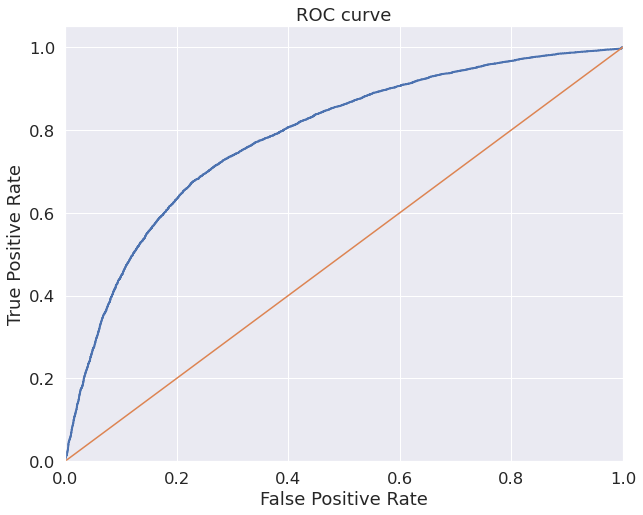

In [21]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()